Importing relevant packages

In [1]:
import pandas as pd
import numpy as np
np.random.seed(1334) 
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from keras.backend import sigmoid
import tensorflow as tf

import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, BatchNormalization, Bidirectional, LeakyReLU

Loading train,test and rul csv files as dataframes to be processed

In [2]:
#Choose either Dataset 1,2,3 or 4
dataset = 4

In [3]:
if dataset == 1:
  train_df= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/train_FD001.txt" ,sep=" ",header=None)
  train_df.drop(columns=[26,27],inplace=True)
  test_df= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/test_FD001.txt",sep=" ",header=None)
  test_df.drop(columns=[26,27],inplace=True)
  rul_df= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/RUL_FD001.txt",sep=" ",header=None)
  rul_df.drop(columns=[1],inplace=True)

elif dataset == 2:
  train_df= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/train_FD002.txt" ,sep=" ",header=None)
  train_df.drop(columns=[26,27],inplace=True)
  test_df= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/test_FD002.txt",sep=" ",header=None)
  test_df.drop(columns=[26,27],inplace=True)
  rul_df= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/RUL_FD002.txt",sep=" ",header=None)
  rul_df.drop(columns=[1],inplace=True)
  
elif dataset == 3:
  train_df= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/train_FD003.txt" ,sep=" ",header=None)
  train_df.drop(columns=[26,27],inplace=True)
  test_df= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/test_FD003.txt",sep=" ",header=None)
  test_df.drop(columns=[26,27],inplace=True)
  rul_df= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/RUL_FD003.txt",sep=" ",header=None)
  rul_df.drop(columns=[1],inplace=True)  

elif dataset == 4:
  train_df= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/train_FD004.txt" ,sep=" ",header=None)
  train_df.drop(columns=[26,27],inplace=True)
  test_df= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/test_FD004.txt",sep=" ",header=None)
  test_df.drop(columns=[26,27],inplace=True)
  rul_df= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/RUL_FD004.txt",sep=" ",header=None)
  rul_df.drop(columns=[1],inplace=True)    

In [4]:
columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_df.columns = columns
test_df.columns = columns                     

Generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values

In [5]:
train_df.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000
mean,124.325181,134.311417,23.999823,0.571347,94.031576,472.882435,579.420056,1417.896600,1201.915359,8.031626,11.589457,283.328633,2228.686034,8524.673301,1.096445,42.874529,266.735665,2334.427590,8067.811812,9.285604,0.023252,347.760029,2228.613283,97.751396,20.864333,12.518995
std,71.995350,89.783389,14.780722,0.310703,14.251954,26.436832,37.342647,106.167598,119.327591,3.622872,5.444017,146.880210,145.348243,336.927547,0.127681,3.243492,138.479109,128.197859,85.670543,0.750374,0.004685,27.808283,145.472491,5.369424,9.936396,5.962697
min,1.000000,1.000000,0.000000,0.000000,60.000000,445.000000,535.480000,1242.670000,1024.420000,3.910000,5.670000,136.170000,1914.720000,7984.510000,0.930000,36.040000,128.310000,2027.570000,7845.780000,8.175700,0.020000,302.000000,1915.000000,84.930000,10.160000,6.084300
25%,60.000000,62.000000,10.004600,0.250700,100.000000,445.000000,549.330000,1350.550000,1119.490000,3.910000,5.720000,142.920000,2211.950000,8320.590000,1.020000,41.760000,134.520000,2387.910000,8062.630000,8.648000,0.020000,330.000000,2212.000000,100.000000,10.940000,6.566100
50%,126.000000,123.000000,25.001400,0.700000,100.000000,462.540000,555.740000,1367.680000,1136.920000,7.050000,9.030000,194.960000,2223.070000,8362.760000,1.030000,42.330000,183.450000,2388.060000,8083.810000,9.255600,0.020000,334.000000,2223.000000,100.000000,14.930000,8.960100
75%,185.000000,191.000000,41.998100,0.840000,100.000000,491.190000,607.070000,1497.420000,1302.620000,10.520000,15.480000,394.280000,2323.930000,8777.250000,1.260000,45.220000,371.400000,2388.170000,8128.350000,9.365800,0.030000,368.000000,2324.000000,100.000000,28.560000,17.135500
max,249.000000,543.000000,42.008000,0.842000,100.000000,518.670000,644.420000,1613.000000,1440.770000,14.620000,21.610000,570.810000,2388.640000,9196.810000,1.320000,48.360000,537.490000,2390.490000,8261.650000,11.066300,0.030000,399.000000,2388.000000,100.000000,39.890000,23.885200


Investigate and remove columns/features that have constant standard deviation values as they do not carry information about the state of the unit

In [ ]:
description = train_df.describe()
description.loc['std']

id           71.995350
cycle        89.783389
setting1     14.780722
setting2      0.310703
setting3     14.251954
s1           26.436832
s2           37.342647
s3          106.167598
s4          119.327591
s5            3.622872
s6            5.444017
s7          146.880210
s8          145.348243
s9          336.927547
s10           0.127681
s11           3.243492
s12         138.479109
s13         128.197859
s14          85.670543
s15           0.750374
s16           0.004685
s17          27.808283
s18         145.472491
s19           5.369424
s20           9.936396
s21           5.962697
Name: std, dtype: float64

Data Pre-processing

In [6]:
# Function for preparing training data and forming a RUL column with information about the remaining

def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('id')['cycle'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['id','max']
    df = df.merge(fd_RUL, on=['id'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df['RUL'] = df['RUL'].clip(upper=180) #clipping
    df.drop(columns=['max'],inplace = True)
    return df[df['cycle'] > factor]

train_df = prepare_train_data(train_df)    

Display mutual correlations of signs using heat map including the newly created RUL column

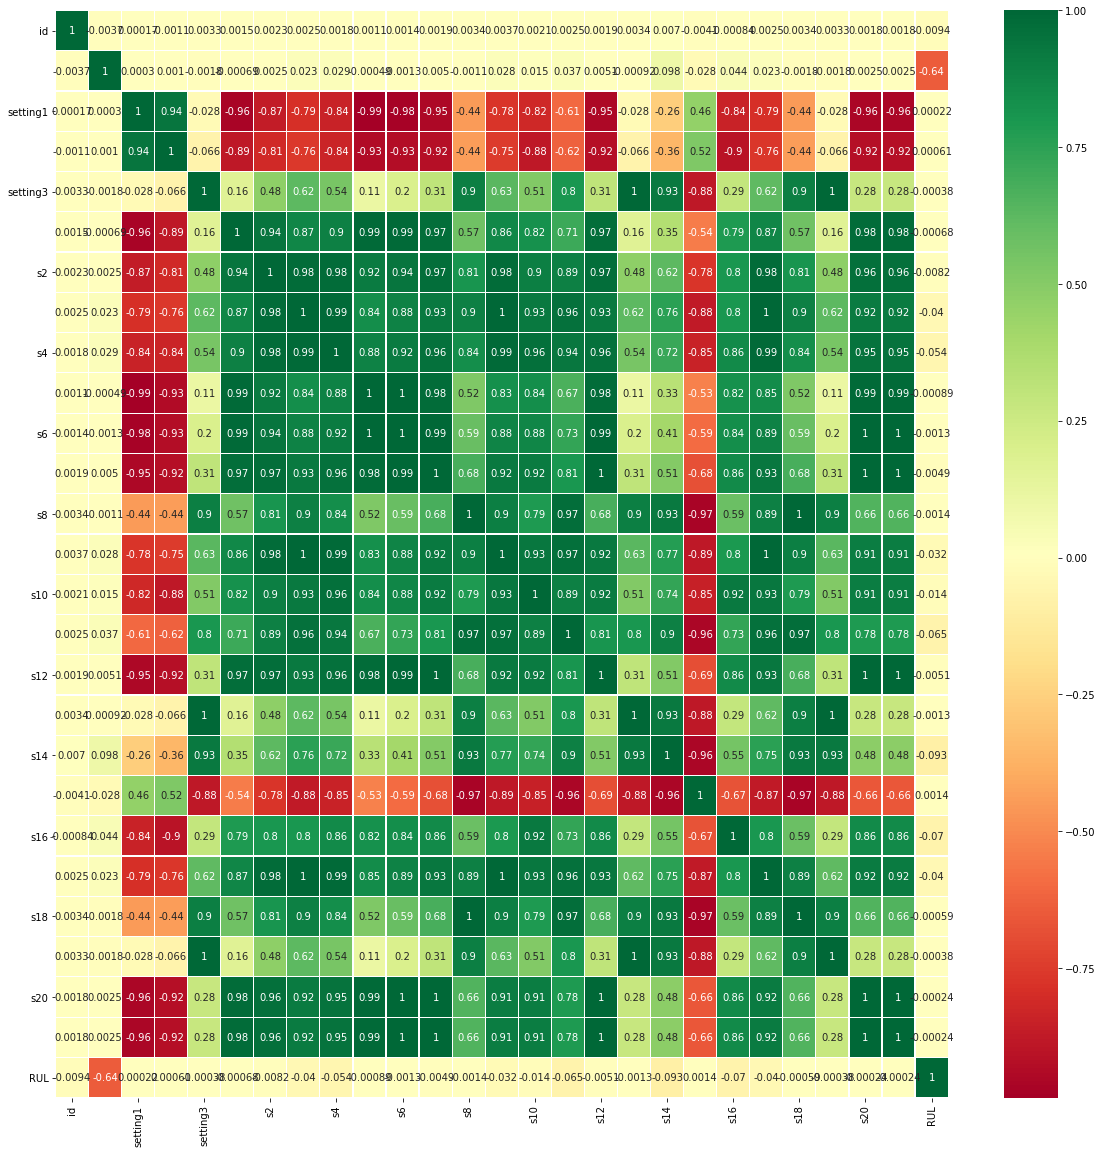

In [7]:
sns.heatmap(train_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

Preprocessing for LSTM

In [8]:
# MinMax normalization (from 0 to 1) train set
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

# MinMax normalization (from 0 to 1) test set
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul_df.columns = ['more']
rul_df['id'] = rul_df.index + 1
rul_df['max'] = rul['max'] + rul_df['more']
rul_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(rul_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df['RUL'] = test_df['RUL'].clip(upper=180)                #clipping
test_df.drop('max', axis=1, inplace=True)

   id  cycle  setting1  setting2  ...  s19       s20       s21  cycle_norm
0   1      1  0.476271  0.831354  ...  1.0  0.475950  0.484043    0.000000
1   1      2  0.595087  0.736342  ...  0.0  0.141271  0.139909    0.001845
2   1      3  0.999810  1.000000  ...  1.0  0.007736  0.019786    0.003690
3   1      4  0.999893  0.997862  ...  1.0  0.013454  0.008561    0.005535
4   1      5  0.833363  0.997625  ...  1.0  0.157753  0.160009    0.007380

[5 rows x 27 columns]


Feature Selection

Rationale of using tsfresh:

tsfresh is a very powerful python package. It automatically calculates a large number of time series characteristics, the so called features. Further the package contains methods to evaluate the explaining power and importance of such characteristics for regression or classification tasks.

Using tsfresh (does not fit this dataset as it requires a dataframe that contains information which robot id reported a failure and not). Our training dataset is a run to failure dataset thus it will not be appropriate.

https://tsfresh.readthedocs.io/en/latest/index.html


In [ ]:
!pip install tsfresh

In [ ]:
%%time
import tsfresh
from tsfresh import extract_features
train_features = train_df[['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3','s4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21']]

CPU times: user 1.04 s, sys: 144 ms, total: 1.19 s
Wall time: 2.61 s


In [ ]:
%%time
extracted_features = extract_features(train_features, column_id="id", column_sort="cycle")

Feature Extraction: 100%|██████████| 5/5 [21:02<00:00, 252.48s/it]


CPU times: user 19 s, sys: 2.36 s, total: 21.4 s
Wall time: 21min 9s


In [ ]:
extracted_features

,setting1__variance_larger_than_standard_deviation,setting1__has_duplicate_max,setting1__has_duplicate_min,setting1__has_duplicate,setting1__sum_values,setting1__abs_energy,setting1__mean_abs_change,setting1__mean_change,setting1__mean_second_derivative_central,setting1__median,setting1__mean,setting1__length,setting1__standard_deviation,setting1__variation_coefficient,setting1__variance,setting1__skewness,setting1__kurtosis,setting1__root_mean_square,setting1__absolute_sum_of_changes,setting1__longest_strike_below_mean,setting1__longest_strike_above_mean,setting1__count_above_mean,setting1__count_below_mean,setting1__last_location_of_maximum,setting1__first_location_of_maximum,setting1__last_location_of_minimum,setting1__first_location_of_minimum,setting1__percentage_of_reoccurring_values_to_all_values,setting1__percentage_of_reoccurring_datapoints_to_all_datapoints,setting1__sum_of_reoccurring_values,setting1__sum_of_reoccurring_data_points,setting1__ratio_value_number_to_time_series_length,setting1__sample_entropy,setting1__maximum,setting1__minimum,setting1__benford_correlation,setting1__time_reversal_asymmetry_statistic__lag_1,setting1__time_reversal_asymmetry_statistic__lag_2,setting1__time_reversal_asymmetry_statistic__lag_3,setting1__c3__lag_1,...,s21__energy_ratio_by_chunks__num_segments_10__segment_focus_4,s21__energy_ratio_by_chunks__num_segments_10__segment_focus_5,s21__energy_ratio_by_chunks__num_segments_10__segment_focus_6,s21__energy_ratio_by_chunks__num_segments_10__segment_focus_7,s21__energy_ratio_by_chunks__num_segments_10__segment_focus_8,s21__energy_ratio_by_chunks__num_segments_10__segment_focus_9,s21__ratio_beyond_r_sigma__r_0.5,s21__ratio_beyond_r_sigma__r_1,s21__ratio_beyond_r_sigma__r_1.5,s21__ratio_beyond_r_sigma__r_2,s21__ratio_beyond_r_sigma__r_2.5,s21__ratio_beyond_r_sigma__r_3,s21__ratio_beyond_r_sigma__r_5,s21__ratio_beyond_r_sigma__r_6,s21__ratio_beyond_r_sigma__r_7,s21__ratio_beyond_r_sigma__r_10,s21__count_above__t_0,s21__count_below__t_0,s21__lempel_ziv_complexity__bins_2,s21__lempel_ziv_complexity__bins_3,s21__lempel_ziv_complexity__bins_5,s21__lempel_ziv_complexity__bins_10,s21__lempel_ziv_complexity__bins_100,s21__fourier_entropy__bins_2,s21__fourier_entropy__bins_3,s21__fourier_entropy__bins_5,s21__fourier_entropy__bins_10,s21__fourier_entropy__bins_100,s21__permutation_entropy__dimension_3__tau_1,s21__permutation_entropy__dimension_4__tau_1,s21__permutation_entropy__dimension_5__tau_1,s21__permutation_entropy__dimension_6__tau_1,s21__permutation_entropy__dimension_7__tau_1,s21__query_similarity_count__query_None__threshold_0.0,"s21__matrix_profile__feature_""min""__threshold_0.98","s21__matrix_profile__feature_""max""__threshold_0.98","s21__matrix_profile__feature_""mean""__threshold_0.98","s21__matrix_profile__feature_""median""__threshold_0.98","s21__matrix_profile__feature_""25""__threshold_0.98","s21__matrix_profile__feature_""75""__threshold_0.98"
1,0.0,0.0,1.0,1.0,186.745979,146.299443,0.401129,6.695153e-08,0.001642,0.595199,0.581763,321.0,0.342510,0.588745,0.117313,-0.320308,-1.131183,0.675101,128.361134,7.0,8.0,185.0,136.0,0.588785,0.585670,0.975078,0.208723,0.288136,0.476636,38.544077,85.373238,0.735202,1.852552,0.999998,0.000002,-0.321485,0.001216,-0.001153,-0.003259,0.183627,...,0.068907,0.127750,0.091482,0.085657,0.100807,0.120259,0.856698,0.339564,0.137072,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.077882,0.199377,0.280374,0.336449,0.442368,0.188113,0.387934,0.744738,1.314414,3.327432,1.790397,3.163215,4.643197,5.532005,5.739370,NaN,1.191652,2.962733,2.198135,2.232427,1.976652,2.475447
2,0.0,0.0,0.0,1.0,170.223843,131.961348,0.385533,6.390601e-08,0.002164,0.595129,0.569311,299.0,0.342386,0.601404,0.117228,-0.259799,-1.138556,0.664336,114.888735,8.0,11.0,164.0,135.0,0.010033,0.006689,0.260870,0.257525,0.287671,0.478261,33.520744,78.183196,0.732441,1.721178,0.999998,0.000000,-0.332394,0.006270,-0.005056,-0.004146,0.180093,...,0.058349,0.095746,0.143183,0.110134,0.104361,0.05

F-Score Selection


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

train_features = train_df[['setting1', 'setting2', 'setting3', 's1', 's2', 's3','s4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21']]
train_labels = train_df['RUL']
selector = SelectKBest(f_classif, k=10)
selected_features = selector.fit_transform(train_features, train_labels)

In [ ]:
selector.scores_

array([1.23800205, 1.03600571, 1.19031546, 1.18122483, 1.1192093 ,
       1.64248567, 2.11529054, 1.18065601, 1.15081626, 1.11832899,
       1.09097283, 1.46721766, 1.14108111, 2.69760176, 1.11768907,
       1.19223914, 4.97650377, 1.14793368, 3.91540349, 1.62152526,
       1.08994218, 1.19031546, 1.12801821, 1.12815032])

In [ ]:
#Finding 20th percentile
lower = np.percentile(selector.scores_, 20)
lower

1.1188571730728512

In [ ]:
c = selector.scores_ >= lower
c.tolist()
index_list = [i for i, x in enumerate(c) if x]
index_list

[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23]

In [ ]:
final_selected_features = []
for i in index_list:
  final_selected_features.append(train_features.columns[i])
  # print(train_features.columns[i])
final_selected_features  

['setting1',
 'setting3',
 's1',
 's2',
 's3',
 's4',
 's5',
 's6',
 's9',
 's10',
 's11',
 's13',
 's14',
 's15',
 's16',
 's17',
 's19',
 's20',
 's21']

Recursive Feature Elimination

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

clf = LinearSVC(C=0.01, penalty="l1", dual=False)
clf.fit(train_features, train_labels)

rfe_selector = RFE(clf, 10)
rfe_selector = rfe_selector.fit(train_features, train_labels)

rfe_values = rfe_selector.get_support()

In [ ]:
rfe_indexes = np.where(rfe_values)[0]

Investigating dependency between sensor groups

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag= 50
test = 'ssr_chi2test'

variables = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21']
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(train_df, variables)      

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints d

,setting1_x,setting2_x,setting3_x,s1_x,s2_x,s3_x,s4_x,s5_x,s6_x,s7_x,s8_x,s9_x,s10_x,s11_x,s12_x,s13_x,s14_x,s15_x,s16_x,s17_x,s18_x,s19_x,s20_x,s21_x
setting1_y,1.0000,0.0080,0.0029,0.0003,0.0010,0.0015,0.0133,0.0099,0.0165,0.0271,0.0018,0.0035,0.0785,0.0046,0.0271,0.0030,0.0156,0.0212,0.1799,0.0017,0.0018,0.0029,0.0181,0.0209
setting2_y,0.0132,1.0000,0.0038,0.0006,0.0001,0.0001,0.0003,0.0023,0.0004,0.0001,0.0006,0.0002,0.0041,0.0007,0.0001,0.0038,0.0049,0.0060,0.0563,0.0001,0.0006,0.0038,0.0001,0.0002
setting3_y,0.0130,0.0036,1.0000,0.0223,0.0238,0.0152,0.0093,0.0145,0.0140,0.0119,0.0217,0.0096,0.0028,0.0078,0.0120,0.0347,0.0002,0.0022,0.0009,0.0174,0.0220,1.0000,0.0118,0.0118
s1_y,0.0062,0.0065,0.0235,1.0000,0.0227,0.0152,0.0182,0.0022,0.0006,0.0006,0.0228,0.0115,0.0045,0.0207,0.0007,0.0236,0.0102,0.0099,0.0145,0.0146,0.0227,0.0235,0.0001,0.0002
s2_y,0.1449,0.0142,0.0224,0.0148,1.0000,0.0009,0.0025,0.1286,0.0967,0.0424,0.0228,0.0008,0.0136,0.0036,0.0412,0.0222,0.0018,0.0052,0.0014,0.0004,0.0230,0.0224,0.0762,0.0694
s3_y,0.0058,0.0009,0.0069,0.0000,0.0000,1.0000,0.0000,0.0007,0.0002,0.0001,0.0000,0.0666,0.0016,0.0000,0.0001,0.0075,0.0000,0.0039,0.0000,0.4202,0.0000,0.0069,0.0000,0.0000
s4_y,0.0000,0.0000,0.0021,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0004,0.0000,0.0024,0.0003,0.0000,0.0000,0.0000,0.0000,0.0021,0.0000,0.0000
s5_y,0.0116,0.0055,0.0060,0.0002,0.0011,0.0026,0.0257,1.0000,0.0149,0.0345,0.0037,0.0060,0.0399,0.0086,0.0348,0.0061,0.0170,0.0254,0.0852,0.0029,0.0037,0.0060,0.0142,0.0243
s6_y,0.0433,0.0025,0.0143,0.0003,0.0019,0.0057,0.0430,0.0333,1.0000,0.0360,0.0087,0.0127,0.0317,0.0199,0.0402,0.0144,0.0140,0.0290,0.0451,0.0064,0.0086,0.0143,0.0051,0.0166
s7_y,0.0642,0.0020,0.0375,0.0005,0.0012,0.0083,0.0778,0.0222,0.0078,1.0000,0.0192,0.0126,0.0159,0.0327,0.3929,0.0380,0.0022,0.0074,0.0172,0.0094,0.0189,0.0375,0.3971,0.2640


Visualize 50 cycles for engine id 3

In [9]:
sequence_length = 50

In [ ]:
# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 3
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]


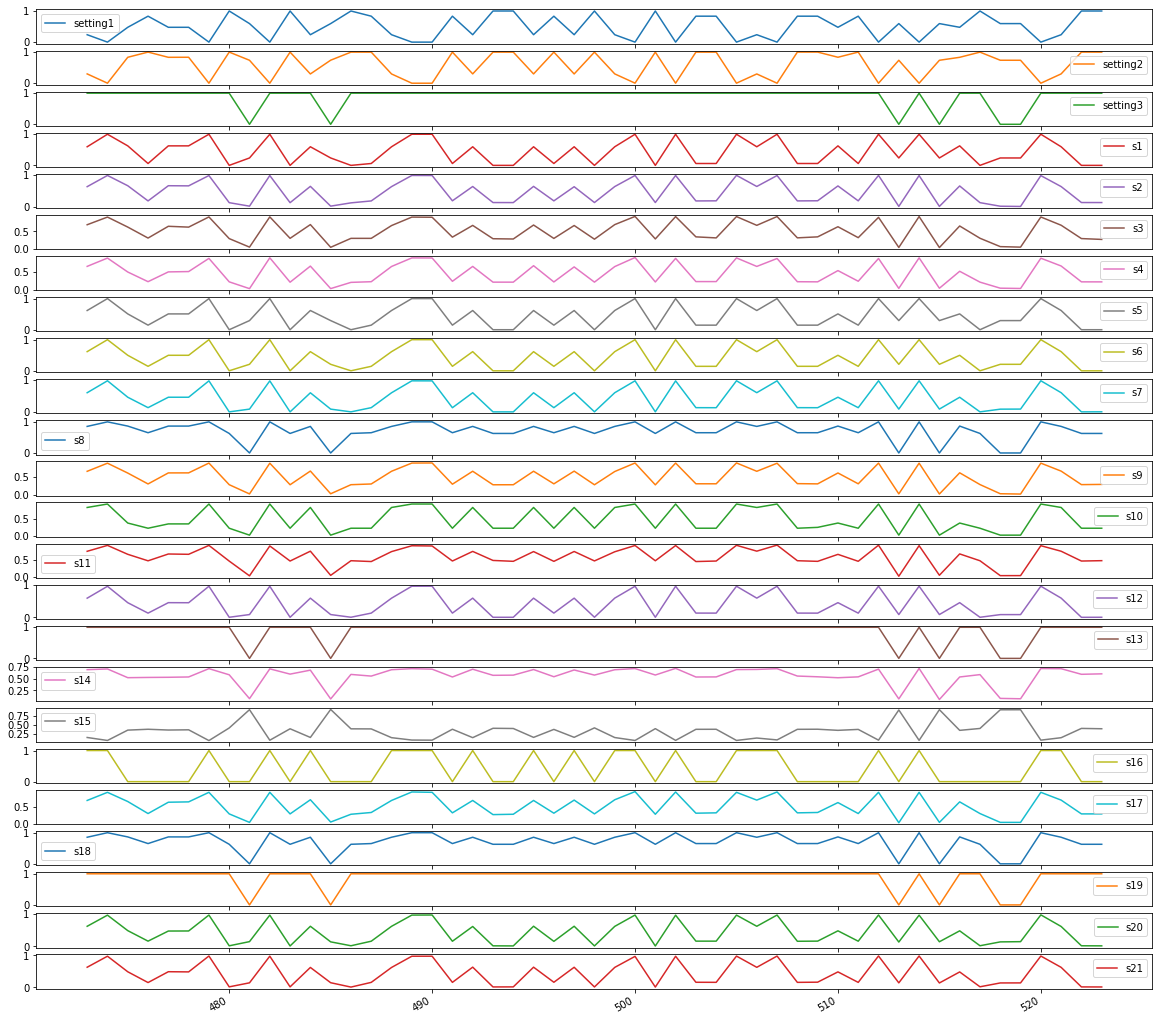

In [ ]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

Data Preparation for LSTM

In [10]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [11]:
# pick the feature columns 
#without removing
sequence_cols = ['cycle_norm','setting1', 'setting2', 'setting3', 's1',
                 's2', 's3', 's4', 's5','s6', 's7', 's8', 's9', 's10', 's11',
       's12', 's13', 's14', 's15','s16', 's17', 's18', 's19', 's20', 's21']

#after feature selection 
# sequence_cols = final_selected_features

seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(48799, 50, 25)

In [12]:
array_shape = seq_array.shape[1] * seq_array.shape[2]
array_shape

1250

In [13]:
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

In [14]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(48799, 1)

In [15]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

LSTM (BASE MODEL)


In [16]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

lstm_model = Sequential()

lstm_model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=50,
         return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(
          units=20,
          return_sequences=False))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units=nb_out, activation='linear'))
lstm_model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse',r2_keras])

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            15200     
_________________________________________________________________
dropout (Dropout)            (None, 50, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [17]:
%%time
# fit the network
fitting = lstm_model.fit(seq_array, label_array, epochs=300, batch_size=32, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='min')])
fitting

Epoch 1/300
1449/1449 [==============================] - 45s 8ms/step - loss: 10948.5864 - mse: 10948.5864 - r2_keras: -2.3192 - val_loss: 6860.4609 - val_mse: 6860.4609 - val_r2_keras: -598274736128.0000
Epoch 2/300
1449/1449 [==============================] - 11s 7ms/step - loss: 6678.7866 - mse: 6678.7866 - r2_keras: -1.0125 - val_loss: 4253.0879 - val_mse: 4253.0879 - val_r2_keras: -378924302336.0000
Epoch 3/300
1449/1449 [==============================] - 11s 8ms/step - loss: 4337.5124 - mse: 4337.5124 - r2_keras: -0.3003 - val_loss: 3386.7825 - val_mse: 3386.7825 - val_r2_keras: -232715829248.0000
Epoch 4/300
1449/1449 [==============================] - 11s 7ms/step - loss: 3630.9226 - mse: 3630.9226 - r2_keras: -0.0787 - val_loss: 3366.1860 - val_mse: 3366.1860 - val_r2_keras: -194189574144.0000
Epoch 5/300
1449/1449 [==============================] - 11s 7ms/step - loss: 3574.4051 - mse: 3574.4051 - r2_keras: -0.0642 - val_loss: 3371.0149 - val_mse: 3371.0149 - val_r2_keras: -1

In [ ]:
lstm_model.save('lstm_model_Adam_50_20.h5')

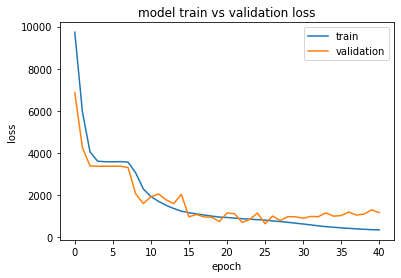

In [18]:
# plot train and validation loss
pyplot.plot(fitting.history['loss'])
pyplot.plot(fitting.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [19]:
# training metrics
scores = lstm_model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))

244/244 [==============================] - 1s 4ms/step - loss: 261.3302 - mse: 261.3302 - r2_keras: -289768416.0000

MSE: 261.3302001953125

R^2: -289768416.0
RMSE: 16.165711


In [20]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(228, 50, 25)

In [21]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

In [22]:
scores_test = lstm_model.evaluate(seq_array_test_last, label_array_test_last, verbose = 1, batch_size = 200)
print('\nMSE: ' + str(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

2/2 [==============================] - 0s 7ms/step - loss: 923.5826 - mse: 923.5826 - r2_keras: 0.7180

MSE: 923.5826416015625

R^2: 0.7179560661315918
RMSE: 30.390502


XGBoost


In [ ]:
## Use XGBoost 
import xgboost as xgb
import matplotlib.pyplot as plt  
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

# Initialize Model
xgb_model = xgb.XGBRegressor(colsample_bytree = 0.5, learning_rate = 0.5,
                max_depth = 6, alpha = 10, n_estimators = 150)

# Train Test Split

X_train = seq_array.reshape(48799, array_shape)
y_train = label_array

X_test = seq_array_test_last.reshape(228, array_shape)
y_test = label_array_test_last

# Model Fitting on Data
xgb_model.fit(X_train, y_train)

# Get Predictions
y_pred = xgb_model.predict(X_test)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))


[05:17:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 29.293043


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(r2_score(y_test, y_pred))
# print(r2_score(label_array_test_last, scores_test))

0.6789567169265798


MLP

In [23]:
# define model
mlp_model = Sequential()
mlp_model.add(Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=(nb_features * 50,)))
mlp_model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(4, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(1))
print(mlp_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                80064     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 82,849
Trainable params: 82,849
Non-trainable params: 0
__________________________________________________

In [24]:
# compile the model
mlp_model.compile(optimizer='rmsprop', loss='mse', metrics=['mse',r2_keras])

In [25]:
# fit the model
mlp_model.fit(seq_array.reshape(48799, array_shape), label_array, epochs=300, batch_size=32, validation_split=0.2, verbose=1,
              callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='auto')])

Epoch 1/300
1220/1220 [==============================] - 5s 3ms/step - loss: 3653.4723 - mse: 3653.4723 - r2_keras: -0.1136 - val_loss: 2048.0334 - val_mse: 2048.0334 - val_r2_keras: -171107221504.0000
Epoch 2/300
1220/1220 [==============================] - 4s 3ms/step - loss: 2252.2906 - mse: 2252.2906 - r2_keras: 0.3280 - val_loss: 1779.4617 - val_mse: 1779.4617 - val_r2_keras: -154277281792.0000
Epoch 3/300
1220/1220 [==============================] - 4s 3ms/step - loss: 1891.6312 - mse: 1891.6312 - r2_keras: 0.4335 - val_loss: 1688.6124 - val_mse: 1688.6124 - val_r2_keras: -59700342784.0000
Epoch 4/300
1220/1220 [==============================] - 4s 3ms/step - loss: 1717.3887 - mse: 1717.3887 - r2_keras: 0.4813 - val_loss: 1454.2642 - val_mse: 1454.2642 - val_r2_keras: -118049652736.0000
Epoch 5/300
1220/1220 [==============================] - 4s 3ms/step - loss: 1672.1057 - mse: 1672.1057 - r2_keras: 0.4948 - val_loss: 2006.0864 - val_mse: 2006.0864 - val_r2_keras: -182462513152.

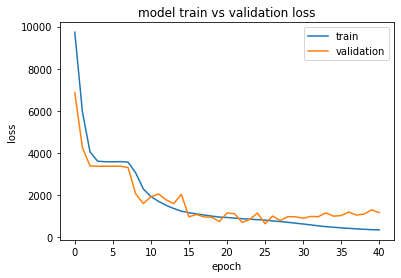

In [26]:
# plot train and validation loss
pyplot.plot(fitting.history['loss'])
pyplot.plot(fitting.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [27]:
# training metrics
scores = mlp_model.evaluate(seq_array.reshape(48799, array_shape), label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))

244/244 [==============================] - 1s 2ms/step - loss: 952.2283 - mse: 952.2283 - r2_keras: -4341481472.0000

MSE: 952.228271484375

R^2: -4341481472.0
RMSE: 30.858196


In [28]:
# test metrics
scores_test = mlp_model.evaluate(seq_array_test_last.reshape(228, array_shape), label_array_test_last, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

2/2 [==============================] - 0s 5ms/step - loss: 1232.1129 - mse: 1232.1129 - r2_keras: 0.5791

MSE: 1232.1129150390625

R^2: 0.579074501991272
RMSE: 35.101466


In [ ]:
mlp_model.save('mlp_model_rmsprop.h5')

Experimenting with other custom activation functions

https://www.bignerdranch.com/blog/implementing-swish-activation-function-in-keras/


In [29]:
#Defining different "Novel" Activation Function

def tanh(x):
    return K.tanh(x)

def lisht(x):
    return (x * K.tanh(x))

def swish(x, beta = 0.8):
    return (x * K.sigmoid(beta * x))

def lrelu001(x,a=0.01):
   return K.maximum(x,a*x)

def penalized_tanh(x):
    alpha = 0.45
    return K.maximum(tanh(x), alpha*tanh(x))

In [32]:
from keras.utils.generic_utils import get_custom_objects

get_custom_objects().update({'swish': swish})
get_custom_objects().update({'lrelu001': lrelu001})
get_custom_objects().update({'penalized_tanh': penalized_tanh})
get_custom_objects().update({'LiSHT': lisht})

Default Tanh (Benchmark)

In [64]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

default_tanh = Sequential()
default_tanh.add(Bidirectional(LSTM(20, return_sequences=True, dropout=0.5), input_shape=(sequence_length, nb_features)))

default_tanh.add(BatchNormalization())

default_tanh.add(LSTM(50, return_sequences=False,  dropout=0.5, activation='tanh'))

default_tanh.add(Dense(units=nb_out))
default_tanh.add(Activation("linear"))
default_tanh.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mse',r2_keras])
print(default_tanh.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 50, 40)            7360      
_________________________________________________________________
batch_normalization_6 (Batch (None, 50, 40)            160       
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)                18200     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 25,771
Trainable params: 25,691
Non-trainable params: 80
_________________________________________________________________
None


In [65]:
# fit the network
%%time
fitting = default_tanh.fit(seq_array, label_array, epochs=50, batch_size=32, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min')])
fitting

Epoch 1/50
1449/1449 [==============================] - 21s 12ms/step - loss: 9321.2143 - mse: 9321.2143 - r2_keras: -1.8348 - val_loss: 3601.8308 - val_mse: 3601.8308 - val_r2_keras: -294478053376.0000
Epoch 2/50
1449/1449 [==============================] - 16s 11ms/step - loss: 3125.9216 - mse: 3125.9216 - r2_keras: 0.0618 - val_loss: 1964.9136 - val_mse: 1964.9136 - val_r2_keras: -87686627328.0000
Epoch 3/50
1449/1449 [==============================] - 16s 11ms/step - loss: 2222.3589 - mse: 2222.3589 - r2_keras: 0.3349 - val_loss: 1737.2140 - val_mse: 1737.2140 - val_r2_keras: -69692653568.0000
Epoch 4/50
1449/1449 [==============================] - 16s 11ms/step - loss: 2071.1470 - mse: 2071.1470 - r2_keras: 0.3764 - val_loss: 4009.1721 - val_mse: 4009.1721 - val_r2_keras: -25643685888.0000
Epoch 5/50
1449/1449 [==============================] - 16s 11ms/step - loss: 1953.7714 - mse: 1953.7714 - r2_keras: 0.4063 - val_loss: 4829.5581 - val_mse: 4829.5581 - val_r2_keras: -2437977088

In [ ]:
default_tanh.save('bilstm_lisht.h5')

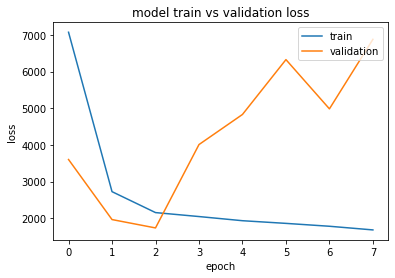

In [66]:
# plot train and validation loss
pyplot.plot(fitting.history['loss'])
pyplot.plot(fitting.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [67]:
# training metrics
scores = default_tanh.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))

244/244 [==============================] - 1s 5ms/step - loss: 6537.5024 - mse: 6537.5024 - r2_keras: -6680893952.0000

MSE: 6537.50244140625

R^2: -6680893952.0
RMSE: 80.854823


In [37]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

In [68]:
#Test Metrics
scores_test = default_tanh.evaluate(seq_array_test_last, label_array_test_last, verbose = 1, batch_size = 200)
print('\nMSE: ' + str(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

2/2 [==============================] - 0s 8ms/step - loss: 8301.9844 - mse: 8301.9844 - r2_keras: -2.0266

MSE: 8301.984375

R^2: -2.026610851287842
RMSE: 91.115226


Swish

In [39]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

swish = Sequential()
swish.add(Bidirectional(LSTM(20, return_sequences=True, kernel_initializer='he_uniform', dropout=0.5), input_shape=(sequence_length, nb_features)))

swish.add(BatchNormalization())

swish.add(LSTM(50, return_sequences=False, kernel_initializer='he_uniform', dropout=0.5, activation='swish'))

swish.add(Dense(units=nb_out))
swish.add(Activation("linear"))
swish.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mse',r2_keras])
print(swish.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 50, 40)            7360      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 40)            160       
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 25,771
Trainable params: 25,691
Non-trainable params: 80
_________________________________________________________________
None


In [40]:
# fit the network
%%time
fitting = swish.fit(seq_array, label_array, epochs=50, batch_size=32, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min')])
fitting

Epoch 1/50
1449/1449 [==============================] - 157s 105ms/step - loss: 66479.9435 - mse: 66479.9435 - r2_keras: -19.4152 - val_loss: 9504.5840 - val_mse: 9504.5840 - val_r2_keras: -795191869440.0000
Epoch 2/50
1449/1449 [==============================] - 152s 105ms/step - loss: 5818458138.9638 - mse: 5818458138.9638 - r2_keras: -1988569.5151 - val_loss: 4015.1406 - val_mse: 4015.1406 - val_r2_keras: -302048378880.0000
Epoch 3/50
1449/1449 [==============================] - 151s 104ms/step - loss: 2630.4601 - mse: 2630.4601 - r2_keras: 0.2059 - val_loss: 3230.7334 - val_mse: 3230.7334 - val_r2_keras: -3616259072.0000
Epoch 4/50
1449/1449 [==============================] - 151s 104ms/step - loss: 2528.7591 - mse: 2528.7591 - r2_keras: 0.2335 - val_loss: 2263.2302 - val_mse: 2263.2302 - val_r2_keras: -31662694400.0000
Epoch 5/50
1449/1449 [==============================] - 151s 104ms/step - loss: 2157.4370 - mse: 2157.4370 - r2_keras: 0.3452 - val_loss: 4866.6802 - val_mse: 4866.

In [ ]:
swish.save('bilstm_lisht.h5')

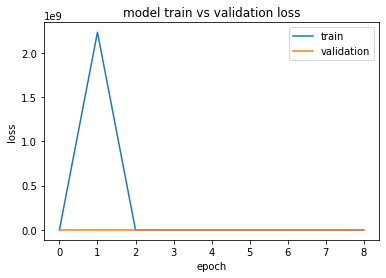

In [41]:
# plot train and validation loss
pyplot.plot(fitting.history['loss'])
pyplot.plot(fitting.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [42]:
# training metrics
scores = swish.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))

244/244 [==============================] - 3s 10ms/step - loss: 4225.9707 - mse: 4225.9707 - r2_keras: -1289256832.0000

MSE: 4225.970703125

R^2: -1289256832.0
RMSE: 65.007467


In [43]:
#Test Metrics
scores_test = swish.evaluate(seq_array_test_last, label_array_test_last, verbose = 1, batch_size = 200)
print('\nMSE: ' + str(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

2/2 [==============================] - 0s 21ms/step - loss: 5672.6821 - mse: 5672.6821 - r2_keras: -0.9936

MSE: 5672.68212890625

R^2: -0.9936193227767944
RMSE: 75.317210


LiSHT

In [44]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

LiSHT = Sequential()
LiSHT.add(Bidirectional(LSTM(20, return_sequences=True, kernel_initializer='he_uniform', dropout=0.5), input_shape=(sequence_length, nb_features)))

LiSHT.add(BatchNormalization())

LiSHT.add(LSTM(50, return_sequences=False, kernel_initializer='he_uniform', dropout=0.5, activation='LiSHT'))

LiSHT.add(Dense(units=nb_out))
LiSHT.add(Activation("linear"))
LiSHT.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mse',r2_keras])
print(LiSHT.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 50, 40)            7360      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 40)            160       
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 25,771
Trainable params: 25,691
Non-trainable params: 80
_________________________________________________________________
None


In [45]:
# fit the network
%%time
fitting = LiSHT.fit(seq_array, label_array, epochs=50, batch_size=32, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min')])
fitting

Epoch 1/50
1449/1449 [==============================] - 152s 102ms/step - loss: 11358956.3365 - mse: 11358956.3365 - r2_keras: -3303.4184 - val_loss: 10894.4912 - val_mse: 10894.4912 - val_r2_keras: -863606603776.0000
Epoch 2/50
1449/1449 [==============================] - 148s 102ms/step - loss: 356903.3803 - mse: 356903.3803 - r2_keras: -108.0472 - val_loss: 2352.1584 - val_mse: 2352.1584 - val_r2_keras: -39975088128.0000
Epoch 3/50
1449/1449 [==============================] - 147s 102ms/step - loss: 2466.4201 - mse: 2466.4201 - r2_keras: 0.2534 - val_loss: 3361.7229 - val_mse: 3361.7229 - val_r2_keras: -4832769024.0000
Epoch 4/50
1449/1449 [==============================] - 147s 102ms/step - loss: 2277.4226 - mse: 2277.4226 - r2_keras: 0.3127 - val_loss: 3427.5115 - val_mse: 3427.5115 - val_r2_keras: -8238897152.0000
Epoch 5/50
1449/1449 [==============================] - 148s 102ms/step - loss: 2155.5487 - mse: 2155.5487 - r2_keras: 0.3439 - val_loss: 5009.6377 - val_mse: 5009.6377

In [ ]:
LiSHT.save('bilstm_lisht.h5')

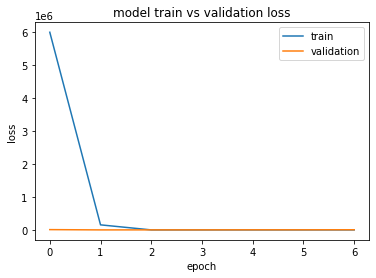

In [46]:
# plot train and validation loss
pyplot.plot(fitting.history['loss'])
pyplot.plot(fitting.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [47]:
# training metrics
scores = LiSHT.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))

244/244 [==============================] - 2s 10ms/step - loss: 6332.9702 - mse: 6332.9702 - r2_keras: -752566656.0000

MSE: 6332.97021484375

R^2: -752566656.0
RMSE: 79.579961


In [48]:
#Test Metrics
scores_test = LiSHT.evaluate(seq_array_test_last, label_array_test_last, verbose = 1, batch_size = 200)
print('\nMSE: ' + str(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

2/2 [==============================] - 0s 11ms/step - loss: 8281.6113 - mse: 8281.6113 - r2_keras: -1.9849

MSE: 8281.611328125

R^2: -1.9849401712417603
RMSE: 91.003359


Leaky Relu

In [49]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

leaky_relu = Sequential()
leaky_relu.add(Bidirectional(LSTM(20, return_sequences=True, kernel_initializer='he_uniform', dropout=0.5), input_shape=(sequence_length, nb_features)))

leaky_relu.add(BatchNormalization())

leaky_relu.add(LSTM(50, return_sequences=False, kernel_initializer='he_uniform', dropout=0.5, activation=keras.layers.LeakyReLU(alpha=0.04)))

leaky_relu.add(Dense(units=nb_out))
leaky_relu.add(Activation("linear"))
leaky_relu.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mse',r2_keras])
print(leaky_relu.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 50, 40)            7360      
_________________________________________________________________
batch_normalization_3 (Batch (None, 50, 40)            160       
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 25,771
Trainable params: 25,691
Non-trainable params: 80
_________________________________________________________________
None


In [50]:
# fit the network
%%time
fitting = leaky_relu.fit(seq_array, label_array, epochs=50, batch_size=32, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min')])
fitting

Epoch 1/50
1449/1449 [==============================] - 126s 84ms/step - loss: 59919826.1993 - mse: 59919826.1993 - r2_keras: -18749.2180 - val_loss: 38795.6836 - val_mse: 38795.6836 - val_r2_keras: -3122412650496.0000
Epoch 2/50
1449/1449 [==============================] - 121s 84ms/step - loss: 4644015.9825 - mse: 4644015.9825 - r2_keras: -1473.4254 - val_loss: 8883.8545 - val_mse: 8883.8545 - val_r2_keras: -718499217408.0000
Epoch 3/50
1449/1449 [==============================] - 122s 84ms/step - loss: 8393.9114 - mse: 8393.9114 - r2_keras: -1.5786 - val_loss: 3350.9258 - val_mse: 3350.9258 - val_r2_keras: -268694192128.0000
Epoch 4/50
1449/1449 [==============================] - 122s 84ms/step - loss: 16921380611.4842 - mse: 16921380611.4842 - r2_keras: -6703101.1135 - val_loss: 11541.0410 - val_mse: 11541.0410 - val_r2_keras: -813816545280.0000
Epoch 5/50
1449/1449 [==============================] - 122s 84ms/step - loss: 2339987.1419 - mse: 2339987.1419 - r2_keras: -733.9062 - va

In [ ]:
leaky_relu.save('leaky_relu.h5')

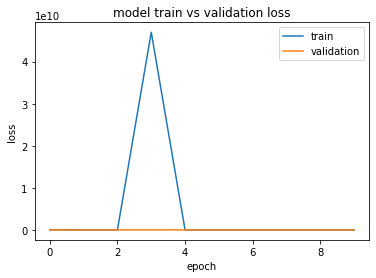

In [51]:
# plot train and validation loss
pyplot.plot(fitting.history['loss'])
pyplot.plot(fitting.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [52]:
# training metrics
scores = leaky_relu.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))

244/244 [==============================] - 2s 9ms/step - loss: 5122.0640 - mse: 5122.0640 - r2_keras: -5652682752.0000

MSE: 5122.06396484375

R^2: -5652682752.0
RMSE: 71.568596


In [53]:
#Test Metrics
scores_test = leaky_relu.evaluate(seq_array_test_last, label_array_test_last, verbose = 1, batch_size = 200)
print('\nMSE: ' + str(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

2/2 [==============================] - 0s 11ms/step - loss: 6755.2427 - mse: 6755.2427 - r2_keras: -1.4452

MSE: 6755.24267578125

R^2: -1.4452258348464966
RMSE: 82.190283


lrelu001

In [54]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

lrelu_001 = Sequential()
lrelu_001.add(Bidirectional(LSTM(20, return_sequences=True, kernel_initializer='he_uniform', dropout=0.5), input_shape=(sequence_length, nb_features)))

lrelu_001.add(BatchNormalization())

lrelu_001.add(LSTM(50, return_sequences=False, kernel_initializer='he_uniform', dropout=0.5, activation='lrelu001'))

lrelu_001.add(Dense(units=nb_out))
lrelu_001.add(Activation("linear"))
lrelu_001.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mse',r2_keras])
print(lrelu_001.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 50, 40)            7360      
_________________________________________________________________
batch_normalization_4 (Batch (None, 50, 40)            160       
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                18200     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 25,771
Trainable params: 25,691
Non-trainable params: 80
_________________________________________________________________
None


In [55]:
# fit the network
%%time
fitting = lrelu_001.fit(seq_array, label_array, epochs=50, batch_size=32, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min')])
fitting

Epoch 1/50
1449/1449 [==============================] - 162s 109ms/step - loss: 18183.5883 - mse: 18183.5883 - r2_keras: -4.5951 - val_loss: 8567.7832 - val_mse: 8567.7832 - val_r2_keras: -680995454976.0000
Epoch 2/50
1449/1449 [==============================] - 158s 109ms/step - loss: 267239.5267 - mse: 267239.5267 - r2_keras: -83.5543 - val_loss: 4562.4814 - val_mse: 4562.4814 - val_r2_keras: -363264606208.0000
Epoch 3/50
1449/1449 [==============================] - 155s 107ms/step - loss: 2415.4319 - mse: 2415.4319 - r2_keras: 0.2728 - val_loss: 2223.0427 - val_mse: 2223.0427 - val_r2_keras: -153920192512.0000
Epoch 4/50
1449/1449 [==============================] - 154s 106ms/step - loss: 2195.9442 - mse: 2195.9442 - r2_keras: 0.3343 - val_loss: 1800.0806 - val_mse: 1800.0806 - val_r2_keras: -108742082560.0000
Epoch 5/50
1449/1449 [==============================] - 156s 108ms/step - loss: 2126.4250 - mse: 2126.4250 - r2_keras: 0.3561 - val_loss: 4458.0752 - val_mse: 4458.0752 - val_

In [ ]:
lrelu_001.save('lrelu_001.h5')

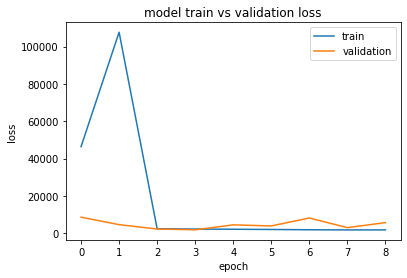

In [56]:
# plot train and validation loss
pyplot.plot(fitting.history['loss'])
pyplot.plot(fitting.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [57]:
# training metrics
scores = lrelu_001.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))

244/244 [==============================] - 2s 10ms/step - loss: 4448.9575 - mse: 4448.9570 - r2_keras: -1036877696.0000

MSE: 4448.95703125

R^2: -1036877696.0
RMSE: 66.700502


In [58]:
#Test Metrics
scores_test = lrelu_001.evaluate(seq_array_test_last, label_array_test_last, verbose = 1, batch_size = 200)
print('\nMSE: ' + str(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

2/2 [==============================] - 0s 17ms/step - loss: 5964.7227 - mse: 5964.7227 - r2_keras: -1.1249

MSE: 5964.72265625

R^2: -1.1249122619628906
RMSE: 77.231617


Penalized Tanh

In [59]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

penalizedtanh = Sequential()
penalizedtanh.add(Bidirectional(LSTM(20, return_sequences=True, kernel_initializer='he_uniform', dropout=0.5), input_shape=(sequence_length, nb_features)))

penalizedtanh.add(BatchNormalization())

penalizedtanh.add(LSTM(50, return_sequences=False, kernel_initializer='he_uniform', dropout=0.5, activation = 'penalized_tanh'))

penalizedtanh.add(Dense(units=nb_out))
penalizedtanh.add(Activation("linear"))
penalizedtanh.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mse',r2_keras])
print(penalizedtanh.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 50, 40)            7360      
_________________________________________________________________
batch_normalization_5 (Batch (None, 50, 40)            160       
_________________________________________________________________
lstm_13 (LSTM)               (None, 50)                18200     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 25,771
Trainable params: 25,691
Non-trainable params: 80
_________________________________________________________________
None


In [60]:
# fit the network
%%time
fitting = penalizedtanh.fit(seq_array, label_array, epochs=50, batch_size=32, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min')])
fitting

Epoch 1/50
1449/1449 [==============================] - 165s 111ms/step - loss: 10024.4130 - mse: 10024.4130 - r2_keras: -2.0103 - val_loss: 4276.3584 - val_mse: 4276.3584 - val_r2_keras: -381497180160.0000
Epoch 2/50
1449/1449 [==============================] - 160s 111ms/step - loss: 4068.4727 - mse: 4068.4727 - r2_keras: -0.2169 - val_loss: 3369.9968 - val_mse: 3369.9968 - val_r2_keras: -191046467584.0000
Epoch 3/50
1449/1449 [==============================] - 160s 110ms/step - loss: 3502.0662 - mse: 3502.0662 - r2_keras: -0.0349 - val_loss: 3377.2107 - val_mse: 3377.2107 - val_r2_keras: -186466615296.0000
Epoch 4/50
1449/1449 [==============================] - 160s 111ms/step - loss: 3313.7802 - mse: 3313.7802 - r2_keras: 0.0151 - val_loss: 2209.2732 - val_mse: 2209.2732 - val_r2_keras: -110506819584.0000
Epoch 5/50
1449/1449 [==============================] - 161s 111ms/step - loss: 2379.8367 - mse: 2379.8367 - r2_keras: 0.2820 - val_loss: 1972.4127 - val_mse: 1972.4127 - val_r2_k

In [ ]:
penalizedtanh.save('penalized_tanh.h5')

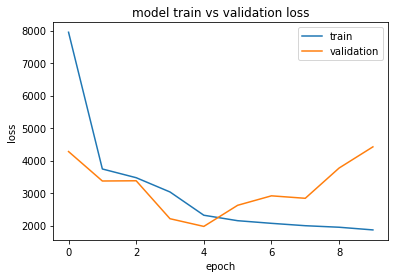

In [61]:
# plot train and validation loss
pyplot.plot(fitting.history['loss'])
pyplot.plot(fitting.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [62]:
# Training metrics
scores = penalizedtanh.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))

244/244 [==============================] - 3s 10ms/step - loss: 3947.8767 - mse: 3947.8767 - r2_keras: -9994878976.0000

MSE: 3947.876708984375

R^2: -9994878976.0
RMSE: 62.832131


In [63]:
#Test Metrics
scores_test = penalizedtanh.evaluate(seq_array_test_last, label_array_test_last, verbose = 1, batch_size = 200)
print('\nMSE: ' + str(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

2/2 [==============================] - 0s 13ms/step - loss: 5216.0996 - mse: 5216.0996 - r2_keras: -0.8717

MSE: 5216.099609375

R^2: -0.8716921210289001
RMSE: 72.222570
